In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [6]:
meters = pd.read_csv('combined_data.csv', parse_dates=True)
meters.head()

,Unnamed: 0,meter_id,w_timestamp,current,voltage,frequency,power_factor,energy,real_power,reactive_power,apparent_power,tita,hour,time_diff
0,0,OND023,2022-07-12 13:57:30.449294+00:00,0.79,210.1,50.1,0.75,NaN,0.124484,0.109785,0.165979,41.409622,14,0.009675
1,1,OND023,2022-07-12 13:58:42.793010+00:00,0.80,210.6,50.0,0.75,0.002539,0.126360,0.111439,0.168480,41.409622,14,0.009675
2,2,OND023,2022-07-12 14:00:28.080361+00:00,0.85,208.3,50.0,0.74,0.003832,0.131021,0.119088,0.177055,42.268584,15,0.009675
3,3,OND023,2022-07-12 14:01:00.914557+00:00,0.74,208.5,50.0,0.76,0.001069,0.117260,0.100277,0.154290,40.535802,15,0.009675
4,4,OND023,2022-07-12 14:01:34.931821+00:00,0.74,208.1,49.9,0.76,0.001106,0.117035,0.100084,0.153994,40.535802,15,0.009675


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306708 entries, 0 to 306707
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      306708 non-null  int64  
 1   meter_id        306708 non-null  object 
 2   w_timestamp     306708 non-null  object 
 3   current         306708 non-null  float64
 4   voltage         306708 non-null  float64
 5   frequency       306708 non-null  float64
 6   power_factor    306708 non-null  float64
 7   energy          306705 non-null  float64
 8   real_power      306708 non-null  float64
 9   reactive_power  306708 non-null  float64
 10  apparent_power  306708 non-null  float64
 11  tita            306708 non-null  float64
 12  hour            306708 non-null  int64  
 13  time_diff       306708 non-null  float64
dtypes: float64(10), int64(2), object(2)
memory usage: 32.8+ MB


In [9]:
def clean(df):
    df = df.copy().dropna(axis='index')
    df = df.drop(columns=['Unnamed: 0','meter_id','tita','hour','time_diff'])
    df = df.rename(columns={'w_timestamp':'timestamp'})
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [7]:
on23 = meters[meters['meter_id'] == "OND023"]
oy21 = meters[meters['meter_id'] == "OYO021"]
on21 = meters[meters['meter_id'] == "OND021"]
on24 = meters[meters['meter_id'] == "OND024"]

In [112]:
df = clean(on23)
df_energy = df[['timestamp','energy']]
df_energy

,timestamp,energy
1,2022-07-12 13:58:42.793010+00:00,0.002539
2,2022-07-12 14:00:28.080361+00:00,0.003832
3,2022-07-12 14:01:00.914557+00:00,0.001069
4,2022-07-12 14:01:34.931821+00:00,0.001106
5,2022-07-12 14:02:10.738666+00:00,0.001164
...,...,...
161079,2022-10-22 21:35:34.272836+00:00,0.003651
161080,2022-10-22 21:36:08.484019+00:00,0.003300
161081,2022-10-22 21:36:43.545834+00:00,0.003368
161082,2022-10-22 21:38:28.735422+00:00,0.007590


In [113]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161083 entries, 1 to 161083
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   timestamp  161083 non-null  datetime64[ns, UTC]
 1   energy     161083 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 3.7 MB


In [150]:
daily_energy = df_energy.set_index('timestamp').resample('D').sum().copy().reset_index()
daily_energy

,timestamp,energy
0,2022-07-12 00:00:00+00:00,2.347196
1,2022-07-13 00:00:00+00:00,4.340452
2,2022-07-14 00:00:00+00:00,4.004731
3,2022-07-15 00:00:00+00:00,4.342706
4,2022-07-16 00:00:00+00:00,5.590642
...,...,...
98,2022-10-18 00:00:00+00:00,2.000048
99,2022-10-19 00:00:00+00:00,0.460232
100,2022-10-20 00:00:00+00:00,2.083481
101,2022-10-21 00:00:00+00:00,1.152627


In [154]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.set_index('timestamp').index.dayofweek
    df['month'] = df.set_index('timestamp').index.month
    df['week'] = df.set_index('timestamp').index.week
    
    
    return df

In [155]:
daily_energy = create_features(daily_energy)

C:\Users\Oluwajuwon\AppData\Local\Temp\ipykernel_11692\47539850.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.set_index('timestamp').index.week


In [156]:
daily_energy

,timestamp,energy,dayofweek,month,week
0,2022-07-12 00:00:00+00:00,2.347196,1,7,28
1,2022-07-13 00:00:00+00:00,4.340452,2,7,28
2,2022-07-14 00:00:00+00:00,4.004731,3,7,28
3,2022-07-15 00:00:00+00:00,4.342706,4,7,28
4,2022-07-16 00:00:00+00:00,5.590642,5,7,28
...,...,...,...,...,...
98,2022-10-18 00:00:00+00:00,2.000048,1,10,42
99,2022-10-19 00:00:00+00:00,0.460232,2,10,42
100,2022-10-20 00:00:00+00:00,2.083481,3,10,42
101,2022-10-21 00:00:00+00:00,1.152627,4,10,42


In [157]:
data_len = len(daily_energy)
test_size = int(0.2*data_len)
train = daily_energy[:-test_size]
test = daily_energy[-test_size:]

In [158]:
train

,timestamp,energy,dayofweek,month,week
0,2022-07-12 00:00:00+00:00,2.347196,1,7,28
1,2022-07-13 00:00:00+00:00,4.340452,2,7,28
2,2022-07-14 00:00:00+00:00,4.004731,3,7,28
3,2022-07-15 00:00:00+00:00,4.342706,4,7,28
4,2022-07-16 00:00:00+00:00,5.590642,5,7,28
...,...,...,...,...,...
78,2022-09-28 00:00:00+00:00,20.363307,2,9,39
79,2022-09-29 00:00:00+00:00,6.586500,3,9,39
80,2022-09-30 00:00:00+00:00,4.668796,4,9,39
81,2022-10-01 00:00:00+00:00,6.316998,5,10,39


In [159]:
test

,timestamp,energy,dayofweek,month,week
83,2022-10-03 00:00:00+00:00,32.549207,0,10,40
84,2022-10-04 00:00:00+00:00,5.080808,1,10,40
85,2022-10-05 00:00:00+00:00,0.926326,2,10,40
86,2022-10-06 00:00:00+00:00,6.637484,3,10,40
87,2022-10-07 00:00:00+00:00,5.116533,4,10,40
88,2022-10-08 00:00:00+00:00,0.000000,5,10,40
89,2022-10-09 00:00:00+00:00,11.182123,6,10,40
90,2022-10-10 00:00:00+00:00,6.808502,0,10,41
91,2022-10-11 00:00:00+00:00,5.402441,1,10,41
92,2022-10-12 00:00:00+00:00,9.011183,2,10,41


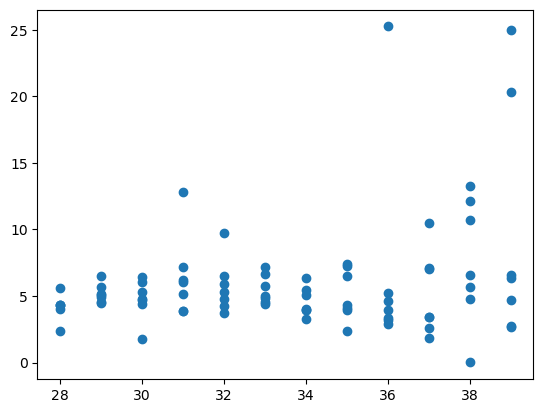

In [160]:
a = train.set_index('timestamp')
plt.scatter(a['week'], a['energy']);

In [161]:
train.columns

Index(['timestamp', 'energy', 'dayofweek', 'month', 'week'], dtype='object')

In [162]:
features = ['dayofweek','month','week']
target = 'energy'

In [163]:
x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [175]:
xgb_reg = xgb.XGBRegressor(n_estimators=1300, learning_rate=0.001)
xgb_reg.fit(x_train,y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose= 100)

[0]	validation_0-rmse:6.81035	validation_1-rmse:8.46045
[100]	validation_0-rmse:6.37802	validation_1-rmse:8.04881
[200]	validation_0-rmse:5.99075	validation_1-rmse:7.71639
[300]	validation_0-rmse:5.63489	validation_1-rmse:7.42079
[400]	validation_0-rmse:5.30956	validation_1-rmse:7.27444
[500]	validation_0-rmse:5.01668	validation_1-rmse:7.15615
[600]	validation_0-rmse:4.75316	validation_1-rmse:7.03683
[700]	validation_0-rmse:4.51313	validation_1-rmse:6.89053
[800]	validation_0-rmse:4.28445	validation_1-rmse:6.75677
[900]	validation_0-rmse:4.06808	validation_1-rmse:6.64959
[1000]	validation_0-rmse:3.86731	validation_1-rmse:6.56577
[1100]	validation_0-rmse:3.68318	validation_1-rmse:6.50967
[1200]	validation_0-rmse:3.51462	validation_1-rmse:6.47896
[1299]	validation_0-rmse:3.35972	validation_1-rmse:6.47013


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

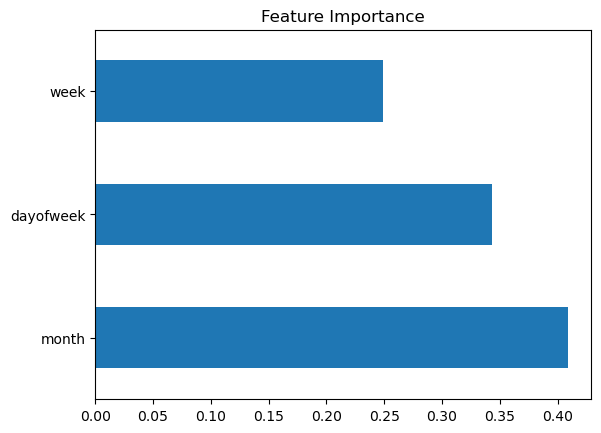

In [176]:
pd.Series(xgb_reg.feature_importances_,index=xgb_reg.feature_names_in_).sort_values(ascending=False)\
.plot(kind='barh',title='Feature Importance');

In [89]:
test['predictions'] = xgb_reg.predict(x_test)

C:\Users\Oluwajuwon\AppData\Local\Temp\ipykernel_11692\1979707022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = xgb_reg.predict(x_test)


In [184]:
test['predictions'] = xgb_reg.predict(x_test)

C:\Users\Oluwajuwon\AppData\Local\Temp\ipykernel_11692\1979707022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = xgb_reg.predict(x_test)


In [185]:
test

,timestamp,energy,dayofweek,month,week,predictions
83,2022-10-03 00:00:00+00:00,32.549207,0,10,40,9.954012
84,2022-10-04 00:00:00+00:00,5.080808,1,10,40,4.383476
85,2022-10-05 00:00:00+00:00,0.926326,2,10,40,8.786907
86,2022-10-06 00:00:00+00:00,6.637484,3,10,40,4.479025
87,2022-10-07 00:00:00+00:00,5.116533,4,10,40,4.676742
88,2022-10-08 00:00:00+00:00,0.000000,5,10,40,3.443460
89,2022-10-09 00:00:00+00:00,11.182123,6,10,40,2.197310
90,2022-10-10 00:00:00+00:00,6.808502,0,10,41,9.954012
91,2022-10-11 00:00:00+00:00,5.402441,1,10,41,4.383476
92,2022-10-12 00:00:00+00:00,9.011183,2,10,41,8.786907


In [179]:
test_energy = test.set_index('timestamp')['energy']
test_energy

timestamp
2022-10-03 00:00:00+00:00    32.549207
2022-10-04 00:00:00+00:00     5.080808
2022-10-05 00:00:00+00:00     0.926326
2022-10-06 00:00:00+00:00     6.637484
2022-10-07 00:00:00+00:00     5.116533
2022-10-08 00:00:00+00:00     0.000000
2022-10-09 00:00:00+00:00    11.182123
2022-10-10 00:00:00+00:00     6.808502
2022-10-11 00:00:00+00:00     5.402441
2022-10-12 00:00:00+00:00     9.011183
2022-10-13 00:00:00+00:00     1.976099
2022-10-14 00:00:00+00:00     4.676101
2022-10-15 00:00:00+00:00     6.312657
2022-10-16 00:00:00+00:00     3.221420
2022-10-17 00:00:00+00:00     3.333189
2022-10-18 00:00:00+00:00     2.000048
2022-10-19 00:00:00+00:00     0.460232
2022-10-20 00:00:00+00:00     2.083481
2022-10-21 00:00:00+00:00     1.152627
2022-10-22 00:00:00+00:00     1.583116
Name: energy, dtype: float64

In [96]:
test_energy = test.set_index('timestamp')['energy'].copy()
predictions = test.set_index('timestamp')['predictions'].copy()

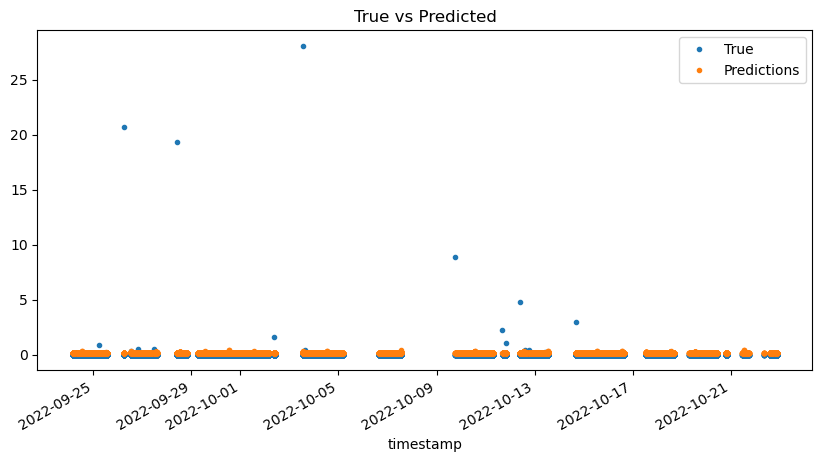

In [101]:
ax = test.plot(style ='.',figsize=(10,5))
predictions.plot(ax=ax, style='.')
plt.legend(['True','Predictions'])
plt.title('True vs Predicted');

In [102]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [104]:
smape(test_energy,predictions)

193.840290709007

In [106]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(test_energy,predictions))

0.2927209584462069

In [111]:
np.abs(test_energy - predictions).sort_values(ascending=False)

timestamp
2022-10-03 13:02:47.038115+00:00    27.881089
2022-09-26 05:37:38.091642+00:00    20.478978
2022-09-28 09:46:35.554955+00:00    19.124745
2022-10-09 18:31:50.668615+00:00     8.685217
2022-10-12 09:46:57.649261+00:00     4.573367
                                      ...    
2022-10-22 08:53:01.784489+00:00     0.088289
2022-10-04 14:08:19.938745+00:00     0.064586
2022-09-25 10:20:24.047887+00:00     0.059667
2022-10-13 10:16:37.965328+00:00     0.032807
2022-09-24 07:54:57.338727+00:00     0.029119
Length: 32216, dtype: float64